In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import random
import pathlib as path
import matplotlib.pyplot as plt
import copy
from os import cpu_count
from tqdm import tqdm
from PIL import Image
from torch.optim import Adam 
from torch.nn import TripletMarginLoss, BCEWithLogitsLoss
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
from torch.nn.functional import pairwise_distance

In [2]:
class Earlystopper:
  def __init__(self, min_delta = 0.0, patience = 1):
    
    self.min_delta = min_delta
    self.patience = patience
    self.best_validation = None
    self.best_model_state = None
    self.counter = 0
    
  def earlystop(self, validation_loss, model):
    
    if self.best_validation is None:
      self.best_validation = validation_loss
      self.best_model_state = copy.deepcopy(model.state_dict())
      
    elif validation_loss <= self.best_validation - self.min_delta:
      
      self.best_validation = validation_loss
      self.best_model_state = copy.deepcopy(model.state_dict())
      self.counter = 0
    
    else:
      self.counter += 1
      
      print(f"Earlystop: {self.counter}/{self.patience}")
      if self.counter >= self.patience:
        return True
    
    return False
       
  def restore_best_weight(self, model):
    if self.best_model_state is not None:
      model.load_state_dict(self.best_model_state)
      print("Restored Best Weight")

In [3]:
def checkpoint(model, epoch):
  file_path = "C:/Users/Porsha Silaroy/Documents/Marvert/python"
  model_name = f"checkpoint{epoch}"
  
  folder_path = os.path.join(file_path, model_name)
  if os.path.exists(folder_path):
    os.remove(folder_path)
    torch.save(model.state_dict(), folder_path)
  else:
    torch.save(model.state_dict(), folder_path)

In [4]:
def Accuracy(dist_A, dist_B):
  margin = 0
  pred = (dist_A - dist_B - margin)
  return (pred > 0).sum()*1.0/dist_A.size()[0]

In [5]:
class SiameseDataset(Dataset):
  def __init__(self, image_dir=None, transform = None):
    
    self.image_dir = image_dir
    self.transform = transform
    
    self.triplet = self.prepare_triplet_data(image_dir)
  
  @classmethod
  def prepare_triplet_data(cls, image_dir_path):
    
    if image_dir_path:
    
      image_path = {}
      triplet = []
      
      for folder in os.listdir(image_dir_path):
      
        Image_dir = os.path.join(image_dir_path, folder)
        if os.path.isdir(Image_dir):
          image_map = [os.path.join(Image_dir, file) for file in os.listdir(Image_dir) if file.lower().endswith(('jpg','png'))]
          if len(image_map) >= 2:
            image_path[folder] = image_map
            
            
      classes = list(image_path.keys())
    
      for folder_dir, image_dir in image_path.items():
          for i in range(len(image_dir)):
            
            anchor = image_dir[i]
            positive = random.choice([file for file in image_dir if file != anchor])
            negative_map = random.choice([Class for Class in classes if Class != folder_dir])
            negative = random.choice([file for file in image_path[negative_map]])
            
            triplet.append([anchor ,positive, negative])
            
      return triplet
        
  def __len__(self):
    return len(self.triplet)
  
  def __getitem__(self, index):
    
    anchor_path, positive_path, negative_path = self.triplet[index]
    
    anchor = Image.open(anchor_path).convert("RGB")
    positive = Image.open(positive_path).convert("RGB")
    negative = Image.open(negative_path).convert("RGB")
    
    if self.transform:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    else:
      
      transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
      ])
      
      anchor = transform(anchor)
      positive = transform(positive)
      negative = transform(negative)
      
    return anchor, positive, negative


image_path = "C:/Users/Porsha Silaroy/Documents/Marvert/image/DataSet/faces/105_classes_pins_dataset"

dataset = SiameseDataset(image_dir= image_path)

In [6]:
def evaluate_data(image_path):
  
  plt.figure(figsize= (9, 3))
  Index = random.randint(0 , len(dataset) - 1)
  dataset_path = SiameseDataset.prepare_triplet_data(image_path)
  data = dataset_path[Index]
  
  for i in range(len(data)):
    
    image = Image.open(data[i]).convert("RGB")
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.asarray(image))
    
    
    plt.axis("off")
  plt.tight_layout()
  plt.show()

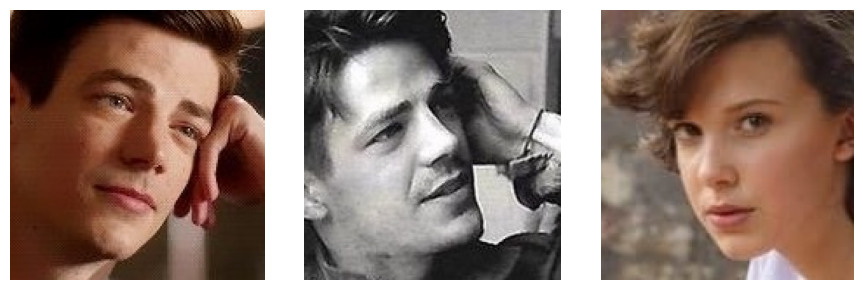

In [7]:
evaluate_data(image_path)

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

generator = torch.Generator()

train_data, test_data = random_split(dataset, [train_size, test_size], generator)

Train_loader = DataLoader(train_data, batch_size= 16, shuffle= True, drop_last= True)
Test_loader = DataLoader(test_data, batch_size=16, shuffle=True, drop_last= True)


In [9]:
print(f"All Data: {len(dataset)}")
print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(test_data)}")

All Data: 17534
Train Data: 14027
Test Data: 3507


In [10]:
class Siamese_network(nn.Module):
  def __init__(self):
    super(Siamese_network, self).__init__()
    
    base_model = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)
    
    self.feature = nn.Sequential(*list(base_model.children())[:-1])
    
    self.fc = nn.Sequential(
      nn.Dropout(0.2, inplace= True),
      nn.Linear(512, 512)
    )
     
  def forward(self, x1, x2, x3 = None):
    
    if x3 is None:
      anchor = self.network(x1)
      positive = self.network(x2)
      
      dist_A = pairwise_distance(anchor, positive)
      
      return (anchor, positive), dist_A
    
    else:
      anchor = self.network(x1)
      positive = self.network(x2)
      negative = self.network(x3)
      
      dist_A = pairwise_distance(anchor, positive)
      dist_B = pairwise_distance(anchor, negative)
      
      return (anchor, positive, negative), dist_A, dist_B
    
  def network(self, x):
    
    x = self.feature(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    
    return x
  

In [11]:
anchor = torch.rand(1, 3, 224, 224)
positive = torch.rand(1, 3, 224, 224)
negative = torch.rand(1, 3, 224, 224)

model = Siamese_network()

output = model(anchor, positive)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Epochs = 15
model = Siamese_network().to(device)
criterion = TripletMarginLoss(margin= 0.3)
optimizer = Adam(model.parameters(), lr = 0.003)
scheduler = ReduceLROnPlateau(optimizer, mode= 'min', factor= 0.5, patience= 2)
earlystop = Earlystopper(min_delta= 0.05, patience= 5)

In [ ]:
acc_stat_A = []
acc_stat_B = []

loss_stat_A = []
loss_stat_B = []

for Epoch in range(Epochs):
  model.train()
  
  running_loss = 0
  running_acc = 0
  
  ProgressBar = tqdm(Train_loader, total= len(Train_loader), desc = f"Epoch: {Epoch + 1} / {Epochs} - Training:", leave = False)
  
  for x_train in ProgressBar:
    
    anchor, positive, negative = [data.to(device) for data in x_train]
    
    embedding, dist_A, dist_B = model(anchor, positive, negative)
    loss = criterion(embedding[0], embedding[1], embedding[2])
    acc = Accuracy(dist_A, dist_B)
    
    running_loss += loss.item()
    running_acc += loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  Train_loss = running_loss / len(Train_loader)
  Train_acc = running_acc / len(Train_loader)
  loss_stat_A.append(Train_loss)
  acc_stat_A.append(Train_acc)

     
  model.eval()
  with torch.inference_mode():
    
    test_running_loss = 0
    test_running_acc = 0
    
    ProgressBar = tqdm(Test_loader, total = len(Test_loader), desc= f"Epoch: {Epoch + 1} / {Epochs} - Testing", leave= False)
    
    for x_test in ProgressBar:

      anchor, positive, negative = [data.to(device) for data in x_test]
      embedding, test_dist_A, test_dist_B = model(anchor, positive, negative)
      test_loss = criterion(embedding[0], embedding[1], embedding[2])
      test_acc = Accuracy(test_dist_A, test_dist_B)
      
      test_running_loss += test_loss.item()
      test_running_acc += test_acc.item()
      
  Test_loss = test_running_loss / len(Test_loader)
  test_acc = test_running_acc / len(Test_loader)
  loss_stat_B.append(Test_loss)
  acc_stat_B.append(test_acc)
  
  scheduler.step(Test_loss)
  
  if earlystop.earlystop(Test_loss, model):
    earlystop.restore_best_weight(model)
    break
  
  checkpoint(model, Epoch)
  
  print(f"Epoch: {Epoch+1}\t|Train Acc: {Train_acc:.02f}%\t|Train Loss: {Train_loss:.02f}%\t|Val Acc: {Test_acc:.02f}%\t|Val Loss: {Test_loss:.02f}%")

Epoch: 1 / 15 - Training::  64%|██████▎   | 557/876 [36:56<26:48,  5.04s/it]  

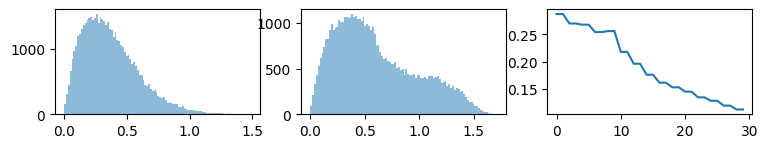

In [ ]:
def visualize_distance(result):
  
  plt.figure(figsize= (9, 3))
  label = ["Accuracy", "Valid Accuracy","Loss", "Valid Loss"]
  
  for i in range(3):
    
    if i < 1:
      plt.subplot(2, 2, i + 1)
      plt.title(label[i])
      plt.plot(result[i])
    else:
      plt.subplot(2, 2, i + 1)
      plt.title(label[i])
      plt.plot(result[i])
        
  
  
  
  
visualize_distance((acc_stat_A, acc_stat_B, loss_stat_A, loss_stat_B))
  

In [ ]:
def save_model(model):

  model_path = "C:/Users/Porsha Silaroy/Documents/Marvert/python/pre_trained_model/"
  model_name = "Siamese_network_triplet2.pth"
  model_save_path = os.path.join(model_path, model_name)

  torch.save(model.state_dict(), model_save_path)


save_model(model)

In [ ]:
def load_model(model_path, model):
  
  assert model_path
  assert model
  weight = torch.load(model_path)
  model.load_state_dict(weight)
  return model

model_path = "C:/Users/Porsha Silaroy/Documents/Marvert/python/pre_trained_model/Siamese_network_triplet2.pth"
model = load_model(model_path, model)

In [ ]:
def evaluate_model(image_path, model):
  
  image =[]
  
  image.clear()
  plt.figure(figsize= (9, 3))
  Index = random.randint(0 , len(dataset) - 1)
  dataset_path = SiameseDataset.prepare_triplet_data(image_path)
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
  ])
  data = dataset_path[Index]
  
  image.append(Image.open(data[0]).convert("RGB"))
  image.append(Image.open(data[1]).convert("RGB"))

  anchor = transform(image[0]).unsqueeze(dim = 0).to(device)
  positive = transform(image[1]).unsqueeze(dim = 0).to(device)
  
  embedding, dist_A, dist_B = model(anchor, positive)
  dist_A = triplet_accuracy(embedding[0], embedding[1])
  acc = Accuracy(dist_A, dist_B, margin= 0.3)
  print(dist_A)
  if dist_A > 0.8:
    print(f"similar\t|Accuracy: {acc}")
  else:
    print(f"not similar\t|Accuracy: {acc}")
  
  for i in range(2):
    
    plt.subplot(1, 2, i + 1)
    plt.imshow(np.asarray(image[i]))

    plt.axis("off")
  plt.tight_layout()
  plt.show()

evaluate_model(image_path, model)
  

ValueError: not enough values to unpack (expected 3, got 2)

<Figure size 900x300 with 0 Axes>